In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Reading the input files
df = pd.read_csv("../../../../Data/Sequence CSVs/All DENVs - DF - sorted.csv", header=None)
dss = pd.read_csv("../../../../Data/Sequence CSVs/All DENVs - DSS - sorted.csv", header=None)
dhf = pd.read_csv("../../../../Data/Sequence CSVs/All DENVs - DHF - sorted.csv", header=None)

# Printing the shape of the data
print("The shape of DF data is:", str(df.shape))
print("The shape of DSS data is:", str(dss.shape))
print("The shape of DHF data is:", str(dhf.shape))

The shape of DF data is: (1081, 1)
The shape of DSS data is: (24, 1)
The shape of DHF data is: (242, 1)


In [3]:
# Making the disease label column
df_disease = np.repeat(0, 1081)
dss_disease = np.repeat(1, 24)
dhf_disease = np.repeat(1, 242)

# Attaching the "Disease" label column to the input
df["Disease"] = df_disease
dss["Disease"] = dss_disease
dhf["Disease"] = dhf_disease

# Renaming the columns
df = df.rename(index=str, columns={0: "Sequence", "Disease": "Disease"})
dss = dss.rename(index=str, columns={0: "Sequence", "Disease": "Disease"})
dhf = dhf.rename(index=str, columns={0: "Sequence", "Disease": "Disease"})

In [4]:
# Concatinating the input data into one DataFrame
result = pd.concat([df, dss, dhf], axis = 0, sort = False)
print("The combined shape of the given data is:", str(result.shape))

# Shuffling the data and then taking a peek
result = result.sample(frac = 1)
print(result.head())

The combined shape of the given data is: (1347, 2)
                                               Sequence  Disease
416   atgaacaaccaacggaaaaagacggctcgaccgtctttcaatatgc...        0
430   atgaataaccaacgaaaaaaggcgagaagtacgcctttcaatatgc...        0
1061  atgaaccaacgaaaaaaggtggttagaccacctttcaatatgctga...        0
89    atgaacaaccaacgaaaaaagacggctcgaccgtctttcaatatgc...        0
135   atgaacaaccaacggaaaaagacggctcgaccgtctttcaatatgc...        0


In [5]:
# Function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size = 7):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

result['words'] = result.apply(lambda x: getKmers(x['Sequence']), axis=1)
result = result.drop('Sequence', axis=1)

result_texts = list(result['words'])
for item in range(len(result_texts)):
    result_texts[item] = ' '.join(result_texts[item])

The shape of y is: (1347,)


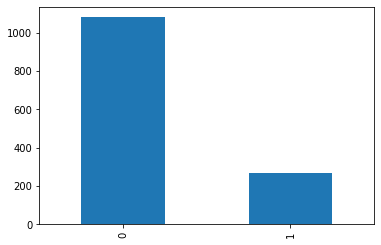

In [6]:
# Creating y and printing the shape of it
y = result.iloc[:, 0].values
print("The shape of y is:", y.shape)

# Checking the balance of the disease severity
result["Disease"].value_counts().sort_index().plot.bar()

In [7]:
# Creating the Bag of Words model using CountVectorizer()
# This is equivalent to k-mer counting
# The n-gram size of 4 was previously determined by testing
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4))
x = cv.fit_transform(result_texts)

# Print the shape of x
print("The shape of x matrix is:", x.shape)

The shape of x matrix is: (1347, 136580)


In [8]:
# Splitting the human dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 42)

# Printing the shapes of the train and test matrices
print("The shape of x_train is:", X_train.shape)
print("The shape of y_train is:", y_train.shape)
print("The shape of x_test is:", X_test.shape)
print("The shape of y_test is:", y_test.shape)

The shape of x_train is: (1077, 136580)
The shape of y_train is: (1077,)
The shape of x_test is: (270, 136580)
The shape of y_test is: (270,)


## Logistic Regression

In [9]:
# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(C = 0.02, random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [10]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))

def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1

print('')

accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = {} \nprecision = {} \nrecall = {} \nf1 = {}".format(accuracy, precision, recall, f1))

Confusion matrix

Predicted    0   1
Actual            
0          218   6
1           14  32

accuracy = 0.9259259259259259 
precision = 0.9230355582442696 
recall = 0.9259259259259259 
f1 = 0.9230483616448528
